<a href="https://colab.research.google.com/github/PraneetVR/IIITDMJ-DL-Summer-School-Program-Assignments/blob/main/Week_3_Day_2_IIITDMJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 3 Day 2 Assignment

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#1. Forward Diffusion Process on MNIST Digits

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def forward_diffusion(x0, timesteps=200):

    xts = []
    variances = []

    x = x0.to(device)
    for t in range(timesteps):
        sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bars[t])
        noise = torch.randn_like(x).to(device)
        xt = sqrt_alpha_bar_t * x + sqrt_one_minus_alpha_bar_t * noise
        xts.append(xt.cpu())
        variances.append(1.0 - alpha_bars[t].cpu().item())

    return xts, variances

dataiter = iter(dataloader)
images, labels = next(dataiter)

num_samples = 3
sample_images = images[:num_samples]

diffused_images_list = []
for img in sample_images:
    xts, _ = forward_diffusion(img.unsqueeze(0))
    diffused_images_list.append(xts)

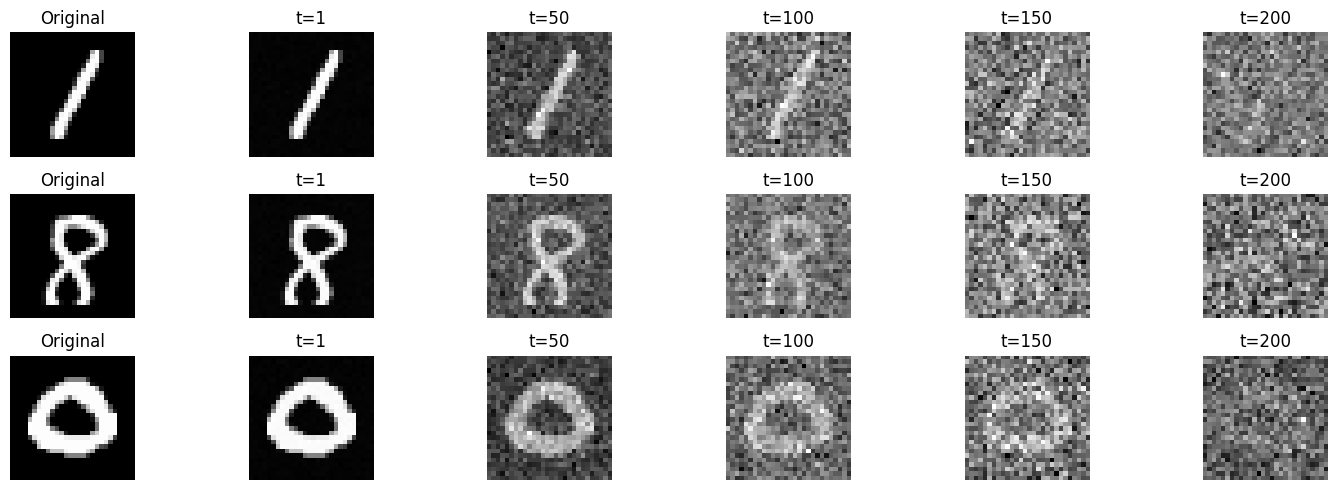

In [ ]:
timesteps_to_show = [1, 50, 100, 150, 200]

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    original_img = sample_images[i]
    plt.subplot(num_samples, len(timesteps_to_show) + 1, i * (len(timesteps_to_show) + 1) + 1)
    plt.imshow(original_img.squeeze().numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for j, t in enumerate(timesteps_to_show):
        diffused_img_at_t = diffused_images_list[i][t - 1]
        plt.subplot(num_samples, len(timesteps_to_show) + 1, i * (len(timesteps_to_show) + 1) + j + 2)
        plt.imshow(diffused_img_at_t.squeeze().numpy(), cmap='gray')
        plt.title(f"t={t}")
        plt.axis('off')

plt.tight_layout()
plt.show()

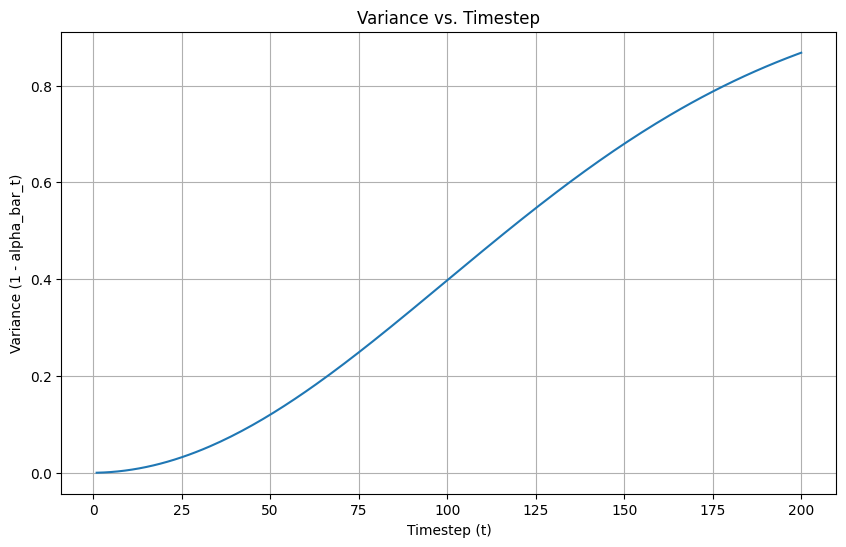

In [ ]:
_, variances = forward_diffusion(sample_images[0].unsqueeze(0)) # Calculate variance for one image

plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), variances)
plt.xlabel("Timestep (t)")
plt.ylabel("Variance (1 - alpha_bar_t)")
plt.title("Variance vs. Timestep")
plt.grid(True)
plt.show()

#2. Backward Denoising Step with a Simple U-Net or Linear Model

Epoch 1/10, Loss: 0.3640
Epoch 2/10, Loss: 0.1734
Epoch 3/10, Loss: 0.1307
Epoch 4/10, Loss: 0.1036
Epoch 5/10, Loss: 0.0831
Epoch 6/10, Loss: 0.0685
Epoch 7/10, Loss: 0.0571
Epoch 8/10, Loss: 0.0483
Epoch 9/10, Loss: 0.0417
Epoch 10/10, Loss: 0.0364


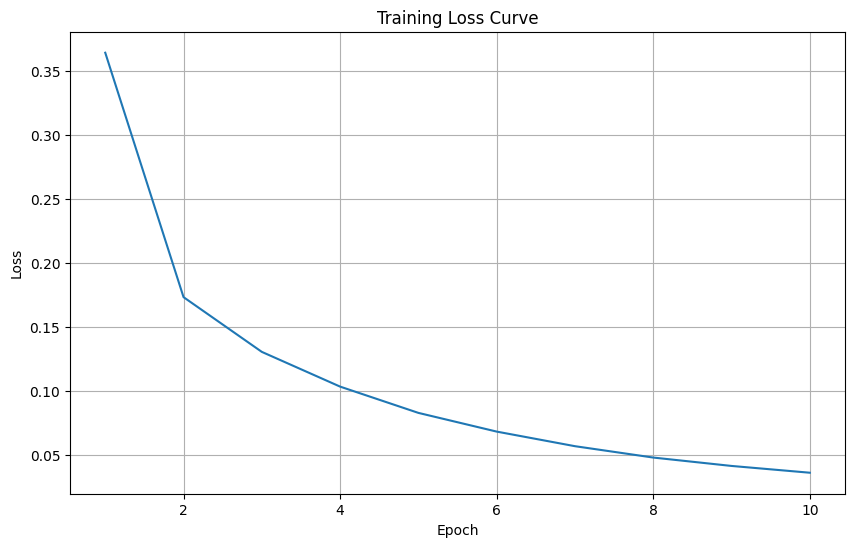

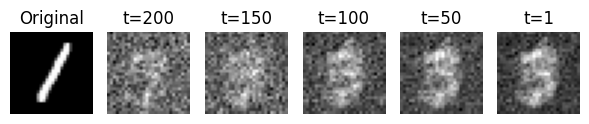

In [ ]:
class DenoisingModel(nn.Module):
    def __init__(self):
        super(DenoisingModel, self).__init__()
        self.linear = nn.Linear(784, 784)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

model = DenoisingModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

timesteps = 200
epochs = 10

train_images, _ = next(iter(dataloader))

noisy_data = []
original_data = []
for img in train_images:
    xts, _ = forward_diffusion(img.unsqueeze(0), timesteps=timesteps)
    for xt in xts:
        noisy_data.append(xt)
        original_data.append(img.unsqueeze(0).cpu())

noisy_data = torch.cat(noisy_data, dim=0)
original_data = torch.cat(original_data, dim=0)

train_dataset = TensorDataset(noisy_data, original_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    for noisy_images, original_images in train_dataloader:
        noisy_images = noisy_images.to(device)
        original_images = original_images.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, original_images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * noisy_images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

sample_original_image = sample_images[0].unsqueeze(0).to(device)

# Generate noisy versions at each timestep
all_xts, _ = forward_diffusion(sample_original_image.cpu(), timesteps=timesteps)

denoised_outputs = []
for t in range(timesteps -1, -1, -1):
    noisy_img_t = all_xts[t].to(device)
    with torch.no_grad():
        denoised_output = model(noisy_img_t)
    denoised_outputs.append(denoised_output.squeeze().cpu().numpy())


timesteps_to_show_denoising = [200, 150, 100, 50, 1]

plt.figure(figsize=(len(timesteps_to_show_denoising) + 1, 3))

# Original Image
plt.subplot(1, len(timesteps_to_show_denoising) + 1, 1)
plt.imshow(sample_original_image.squeeze().cpu().numpy(), cmap='gray')
plt.title("Original")
plt.axis('off')

# Denoised Images
for i, t in enumerate(timesteps_to_show_denoising):
    denoised_idx = (timesteps -1) - (t - 1)
    if denoised_idx < len(denoised_outputs):
        plt.subplot(1, len(timesteps_to_show_denoising) + 1, i + 2)
        plt.imshow(denoised_outputs[denoised_idx], cmap='gray')
        plt.title(f"t={t}")
        plt.axis('off')

plt.tight_layout()
plt.show()

#3. Class-Conditional Diffusion

Conditional Epoch 1/10, Loss: 0.9342
Conditional Epoch 2/10, Loss: 0.8925
Conditional Epoch 3/10, Loss: 0.8873
Conditional Epoch 4/10, Loss: 0.8836
Conditional Epoch 5/10, Loss: 0.8811
Conditional Epoch 6/10, Loss: 0.8796
Conditional Epoch 7/10, Loss: 0.8781
Conditional Epoch 8/10, Loss: 0.8774
Conditional Epoch 9/10, Loss: 0.8769
Conditional Epoch 10/10, Loss: 0.8765
Generating for class: 0
Generating for class: 1
Generating for class: 2


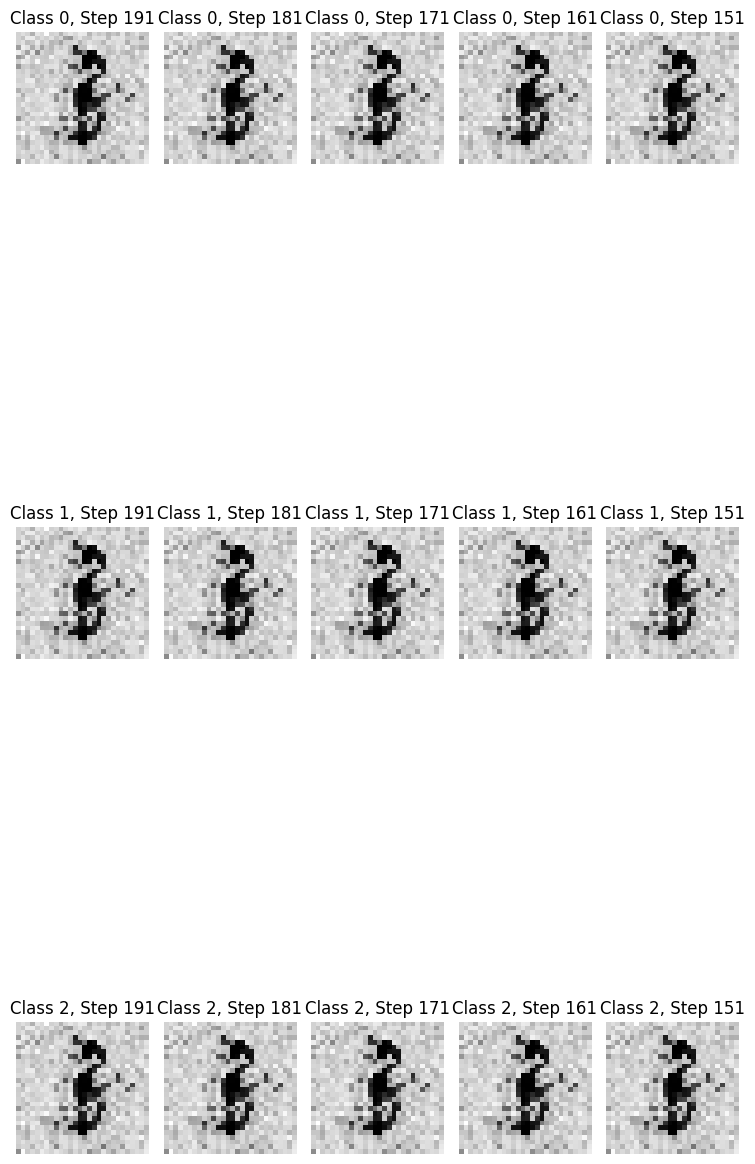

In [ ]:
class ConditionalDenoisingModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalDenoisingModel, self).__init__()
        self.linear_image = nn.Linear(784, 784)
        self.linear_label = nn.Linear(num_classes, 784)
        self.relu = nn.ReLU()

    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        label_embedding = self.linear_label(labels)
        combined_input = x + label_embedding
        x = self.relu(self.linear_image(combined_input))
        x = x.view(x.size(0), 1, 28, 28)
        return x

conditional_model = ConditionalDenoisingModel().to(device)
conditional_criterion = nn.MSELoss()
conditional_optimizer = optim.Adam(conditional_model.parameters(), lr=1e-3)

train_images_conditional, train_labels_conditional = next(iter(dataloader))

noisy_data_conditional = []
original_data_conditional = []
labels_data_conditional = []

for img, label in zip(train_images_conditional, train_labels_conditional):
    xts, _ = forward_diffusion(img.unsqueeze(0), timesteps=timesteps)
    one_hot_label = torch.eye(10)[label].unsqueeze(0)
    for xt in xts:
        noisy_data_conditional.append(xt)
        original_data_conditional.append(img.unsqueeze(0).cpu())
        labels_data_conditional.append(one_hot_label)

noisy_data_conditional = torch.cat(noisy_data_conditional, dim=0)
original_data_conditional = torch.cat(original_data_conditional, dim=0)
labels_data_conditional = torch.cat(labels_data_conditional, dim=0)


conditional_train_dataset = TensorDataset(noisy_data_conditional, original_data_conditional, labels_data_conditional)
conditional_train_dataloader = DataLoader(conditional_train_dataset, batch_size=32, shuffle=True)

conditional_loss_history = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for noisy_images, original_images, labels in conditional_train_dataloader:
        noisy_images = noisy_images.to(device)
        original_images = original_images.to(device)
        labels = labels.to(device)

        conditional_optimizer.zero_grad()
        outputs = conditional_model(noisy_images, labels)
        loss = conditional_criterion(outputs, original_images)
        loss.backward()
        conditional_optimizer.step()
        running_loss += loss.item() * noisy_images.size(0)

    epoch_loss = running_loss / len(conditional_train_dataset)
    conditional_loss_history.append(epoch_loss)
    print(f"Conditional Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

target_classes = [0, 1, 2]
num_steps_generate = 50

plt.figure(figsize=(len(target_classes) * 3, num_steps_generate // 10 * 3))

for class_idx in target_classes:
    print(f"Generating for class: {class_idx}")
    x_t = torch.randn(1, 1, 28, 28).to(device)
    conditional_label = torch.eye(10)[class_idx].unsqueeze(0).to(device)

    generated_images = []
    for t in range(timesteps - 1, timesteps - num_steps_generate - 1, -1):
         with torch.no_grad():
             denoised_output = conditional_model(x_t, conditional_label)
         generated_images.append(denoised_output.squeeze().cpu().numpy())

         if t > 0:
             noise_to_add = torch.randn_like(x_t) * torch.sqrt(torch.tensor(1.0 - (1.0 - betas[t].cpu().item())))
             x_t = denoised_output + noise_to_add.to(device)

    for i, step_img in enumerate(generated_images):
        if (i + 1) % 10 == 0 or i == 0 or i == len(generated_images) - 1:
            plt.subplot(len(target_classes), num_steps_generate // 10 + 1, target_classes.index(class_idx) * (num_steps_generate // 10 + 1) + i // 10 + 1)
            plt.imshow(step_img, cmap='gray')
            plt.title(f"Class {class_idx}, Step {timesteps - i}")
            plt.axis('off')

plt.tight_layout()
plt.show()


#4. Text-to-Image with Pretrained Stable Diffusion

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image for: A cat playing piano


  0%|          | 0/50 [00:00<?, ?it/s]

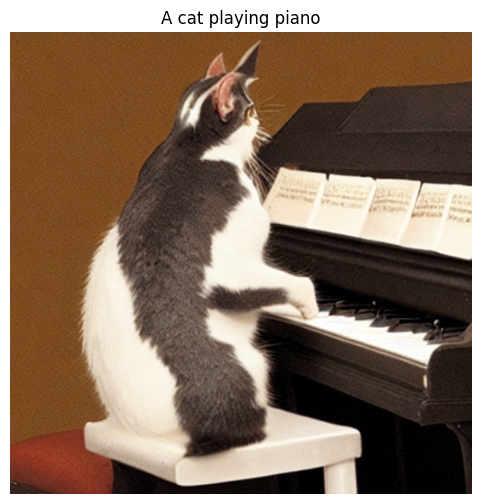

Generating image for: A fantasy castle at night


  0%|          | 0/50 [00:00<?, ?it/s]

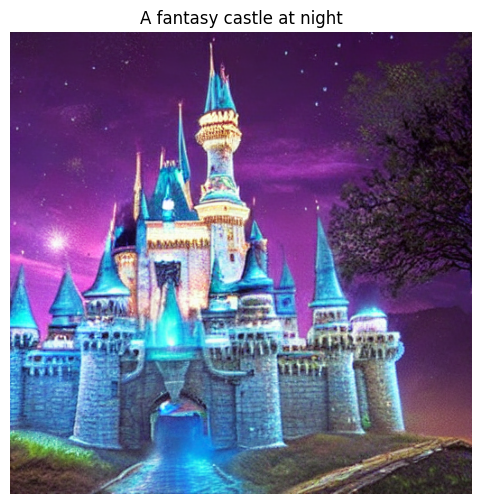

Generating image for: A spaceship landing on a foreign planet


  0%|          | 0/50 [00:00<?, ?it/s]

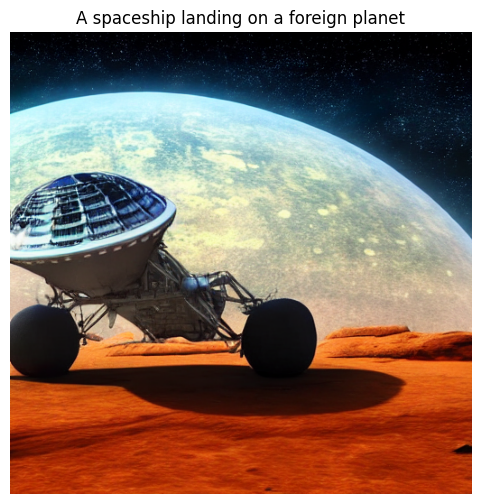

In [ ]:
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompts = [
    "A cat playing piano",
    "A fantasy castle at night",
    "A spaceship landing on a foreign planet" # Added an extra prompt
]

for prompt in prompts:
    print(f"Generating image for: {prompt}")
    image = pipe(prompt).images[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis('off')
    plt.show()